# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. A current [pre-print paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10402116/) has already preprocessed the dataset and created homology reduced data splits. We will reuse these. To do so, download the data folder from [here](https://polybox.ethz.ch/index.php/s/txvcb5jKy1A0TbY) and unzip it.  

The data includes measurements of changes in the Gibbs free enrgy ($\Delta \Delta G $). 
This will be the value that you will have to predict for a given protein with a point mutation. 
As input data you can use the protein sequence or a protein embedding retreived from ESM, a state of the art protein model.  

Here we will use protein embeddings computed by ESM as input. 
We provide precomputed embeddings from the last layer of the smallest ESM model. You can adjust the Dataloader's code to load the embedding of the wild type or of the mutaed sequence or both. You can use it however you like. This is just to provide you easy access to embeddings. If you want to compute your own embeddings from other layers or models you can do that, too. 

Below we provide you with a strcuture for the project that you can start with.  
Edit the cells to your liking and add more code to create your final model.

## Imports

In [2]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L
import os
import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.  
As mentioned, we provide embeddings from the last layer of ESM as input. You can access either the wild type or the mutated sequence and you could also further adjsut the embeddings. 
Here we have an embedding representing the complete sequence. It was computed by averaging over the embeddings per residue in the sequence. 

The ``Dataset`` classes return tuples of ``(embedding, ddg_value)``.

In [3]:
def goOneUp():
    path_parent = os.path.dirname(os.getcwd())

    os.chdir(path_parent)
    os.getcwd()
#goOneUp()

In [5]:
os.getcwd()

'/home/course/ProteinStabilityNN'

In [6]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    if sequence != "0":
        for i, aa in enumerate(sequence):
            # set the column corresponding to the amino acid to 1
            one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot
    


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        
        self.min_size = 72
        
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        
        """
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)
            for i in range(self.min_size-len(self.encoded_seqs[wt_name])):
                #print(wt_name, i)
                self.encoded_seqs[wt_name] = torch.cat((self.encoded_seqs[wt_name], one_hot_encode("0")),0)
         """
        
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((1, len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
     
        
        
        return {"sequence": sequence_encoding[None,:,:].float(), "mask": mask, "labels": target}

In [8]:
# usage
dataset_train = SequenceData('project_data/project_data/mega_train.csv')
dataset_val= SequenceData('project_data/project_data/mega_val.csv')
dataset_test = SequenceData('project_data/project_data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

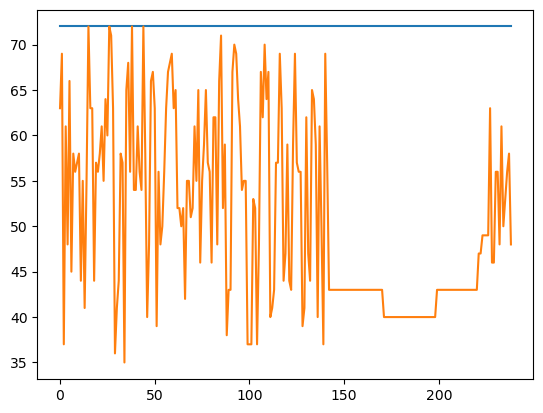

In [9]:

plt.plot([len(dataset_train.encoded_seqs[seq]) for seq in dataset_train.encoded_seqs.keys()])
#max([len(dataset_train.encoded_seqs['1A32.pdb']) for seq in range(len(dataset_train.encoded_seqs))])
    
plt.plot([len(dataset_train.df["aa_seq"][seq][0]) for seq in range(len(dataset_train.df))])
#max([len(dataset_train.df["aa_seq"][seq][0]) for seq in range(len(dataset_train.df))])
    

In [10]:
# take first batch from the train loader
batch = next(iter(dataloader_train))

## Model architecture and training

Now it's your turn. Create a model trained on the embeddings and the corresponding ddG values.  
Be aware that this is not a classification task, but a regression task. You want to predict a continuous number that is as close to the measured $\Delta \Delta G $ value as possible.
You will need to adjust your architecture and loss accordingly.

Train the model with the predefined dataloaders. And try to improve the model. 
Only test on the test set at the very end, when you have finished fine-tuning you model. 

In [11]:
def get_conv2d_out_shape(tensor_shape, conv, pool = 2):
    # return the new shape of the tensor after a convolution and pooling
    # tensor_shape: (channels, height, width)
    # convolution arguments
    kernel_size = conv.kernel_size
    stride=conv.stride # 2D array
    padding=conv.padding # 2D array
    dilation=conv.dilation # 2D array
    out_channels = conv.out_channels
    height_out = np.floor((tensor_shape[1]+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    #width_out = np.floor((tensor_shape[2]+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        # adjust dimensions to pooling
        height_out/=pool
        #width_out/=pool
        
    return int(out_channels),int(height_out)#,int(width_out)

In [12]:
batch[0].shape[1]

KeyError: 0

In [68]:
# your code
class MRIModel(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(MRIModel, self).__init__() #initialize parent pytorch module

        # read parameters
        shape_in = params["shape_in"]
        batch_size = params["batch_size"] 
        #fc1_size = params["fc1_size"]
        
        #### Convolution Layers
        self.dropout = nn.Dropout(0.3)
        # Max pooling layer
        self.pool = nn.MaxPool1d(2)

        ##conv layer 1
        # convolution with kernel size 8, goes from three channels to 
        # number defined by initial_depth in params
        self.conv1 = nn.Conv1d(shape_in[0], shape_in[0], kernel_size= 30, padding= 0) #(kernel_size-1)/2
        shapeself.conv2 = nn.Conv1d(shape_in[0], shape_in[0], kernel_size= 30, padding= 0)
        ############### TODO ################
        # get current shape after conv1, use helper function get_conv2d_out_shape, use pool=2
        ##current_data_shape = get_conv2d_out_shape(shape_in, self.conv1, pool= 2)
        
        ##conv layer 2
        # convolution with kernel size 4, double the amount of channels
        #self.conv2 = nn.Conv2d(shape_in[0], shape_in[0], kernel_size = 15, padding = 7) #
        # get current shape after conv2, use pool=2 again
        ##current_data_shape = get_conv2d_out_shape(current_data_shape, self.conv2, pool=0)

        #### Fully connected layers
        # compute the flattened size as input for fully connected layer
        ##flat_size = current_data_shape[1] * batch_size
        #print(current_data_shape)
        # linear layer reduces data from flat_size to fc1_size
        self.fc1 = nn.Linear(shape_in[1] - 29, 1) # shape_in - (kernel_size - 1) (ohne pooling, padding)
        self.fc1 = nn.Linear(shape_in[1] - 2*29, 1) 
        # last linear layer reduces data to output size 1
        #self.fc2 = nn.Linear(current_data_shape[1], current_data_shape[1])
        #self.fc3 = nn.Linear(current_data_shape[1], 1)
        
        #####################################
        

    def forward(self, X):
        # our network's forward pass
        
        # Convolution & Pool Layers
        ############# TODO ###############
        # convolution (conv1), then relu, then max pool 
        X = F.relu(self.conv1(X)) #leaky_relu 1.119, tanh 1.5926 (only positive values), sigmoid 1.2797 (only positive values?) RMSE
        X = self.dropout(X)
        X = F.relu(self.conv2(X))
        ##X = self.pool(X)
        # convolution (conv2), then relu, then max pool 
        ##X = self.conv2(X)

        ##X = torch.flatten(X, 1) # flatten all dimensions except batch

        # fully connected layer and ReLU
        X = self.fc1(X)
        

        #####################################
        # return log softmax to fit classification problem, no relu needed
        return X

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LitMRIModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        ######## TODO ##########
        # pass our model 
        self.model = model
        #pass the learning rate
        self.lr = learning_rate
        # define loss function
        
        self.loss_function = nn.MSELoss(reduction="mean")
        # define accuracy metric (torchmetrics)
        #self.accuracy = torchmetrics.classification.MulticlassAccuracy() #change
        ########################

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        ######### TODO #############
        
        # read from batch
        x, y = batch
        x = torch.unsqueeze(x, 1)
        # run data through model
        predictions = self.model(x)
        predictions = predictions.squeeze(1).squeeze(1)
        # compute loss
        loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions, y)
        ##############################

        # logging the values (will appear in progress bar and on dashboard)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        ############## TODO ################
        # define the optimizer, let's use Adam
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        ####################################
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop

        ############### TODO #############
        # read from batch
        x, y = batch
        x = torch.unsqueeze(x, 1)
        # run data through model
        predictions = self.model(x)
        predictions = predictions.squeeze(1).squeeze(1)
        # compute loss
        loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("test_loss", loss, prog_bar=True)
        #self.log("test_acc", acc, prog_bar=True)
        return loss#, acc


    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        ############### TODO #############
        # read from batch
        x, y = batch
        x = torch.unsqueeze(x, 1)
        # run data through model
        predictions = self.model(x)
        predictions = predictions.squeeze(1).squeeze(1)
        # compute loss
        loss = self.loss_function(predictions, y)
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss 
    

In [70]:
params_model={"shape_in": (1, batch[0].shape[1]), # size of our dataset - 768 (nr of neurons), 1024 (batch size)
        "batch_size": 1024} #1 - 2x192, 384x7
        #"fc1_size": 7}

# Instantiate the model
cnn_model = MRIModel(params_model)
# instantiate lightning model with the cnn_model and learning_rate=1e-3
model = LitMRIModel(cnn_model, learning_rate=1e-3)
############################

# instantiate the lightning trainer 
trainer = L.Trainer(max_epochs=20, log_every_n_steps=1)
# train
trainer.fit(model, dataloader_train, dataloader_val)

trainer.validate(model, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | model         | MRIModel | 773   
1 | loss_function | MSELoss  | 0     
-------------------------------------------
773       Trainable params
0         Non-trainable params
773       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8008595705032349
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8008595705032349}]

In [71]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/ --host localhost --port=8001

Reusing TensorBoard on port 8008 (pid 2828906), started 5:50:35 ago. (Use '!kill 2828906' to kill it.)

## Validation and visualization

To get a good feeling of how the model is performing and to compare with literature, compute the Pearson and Spearman correlations.
You can also plot the predictions in a scatterplot. We have added some code for that. 

RMSE: 0.91141546
Pearson r: PearsonRResult(statistic=0.2305191904921676, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.21456514463629098, pvalue=4.8260473042741635e-282)


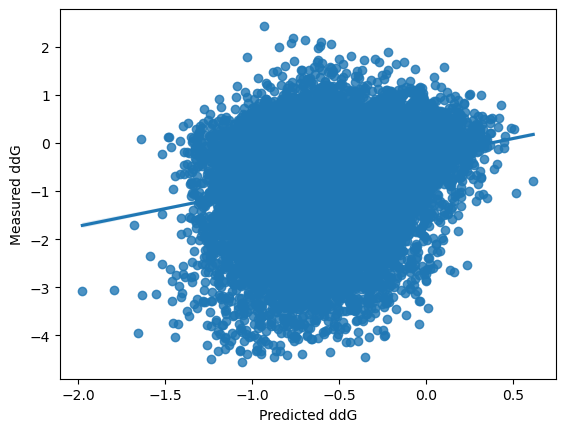

In [66]:
preds =[]
all_y = []
# save all predictions
for batch in dataloader_val:
    # adjust this to work with your model
    x,y = batch
    x = torch.unsqueeze(x, 1)
    y_hat = cnn_model(x)
    preds.append(y_hat.squeeze().detach().numpy())
    all_y.append(y.detach().numpy())

# concatenate and plot
preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared = False))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))